In [1]:
%pylab inline

import pandas as pd
import numpy as np
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import altair as alt
alt.data_transformers.enable('default', max_rows=None)

Populating the interactive namespace from numpy and matplotlib


DataTransformerRegistry.enable('default')

# 데이터 확인

In [2]:
# Data load

train = pd.read_csv('./train_job/train.csv')            # usesr - job 지원 여부 matrix (Train set)
test = pd.read_csv('./test_job.csv')                    # usesr - job 지원 여부 matrix (Test set)
user_tags = pd.read_csv('./train_job/user_tags.csv')    # 사용자 정보 (1:N)
job_tags = pd.read_csv('./train_job/job_tags.csv')      # 업무 정보 (1:N)
tags = pd.read_csv('./train_job/tags.csv')              # keyword
company = pd.read_csv('./train_job/job_companies.csv')  # company info

train.head()

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1
3,f862b39f767d3a1991bdeb2ea1401c9c,3b5dca501ee1e6d8cd7b905f4e1bf723,0
4,cac14930c65d72c16efac2c51a6b7f71,287e03db1d99e0ec2edb90d079e142f3,0


## 기초 분석

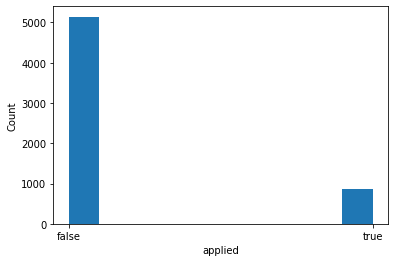

In [3]:
plt.hist(train['applied'])
plt.xlabel("applied")
plt.ylabel("Count")
plt.xticks([0,1], ['false', 'true'])
plt.show()

In [4]:
train.describe(include=[np.object])

,userID,jobID
count,6000,6000
unique,196,708
top,b052e2e0c0ad1b2d5036bd56e27d061c,da0d1111d2dc5d489242e60ebcbaf988
freq,106,50


In [5]:
# job_keyword
# job_keywords

job_keyword = pd.merge(job_tags, tags)[['jobID','keyword']]
job_keyword['keyword'] = job_keyword['keyword'].apply(lambda x : x.lower()) # 소문자로 변경
job_keyword['keyword'] = job_keyword['keyword'].apply(lambda x : x.strip()) # 공백 제거

# row 레벨의 job 관심 keyword 를 리스트로 저장
job_keywords = []

for _id, _data in list(job_keyword.groupby(by='jobID', axis=0)):
    job_keywords.append([_id, list(set([value for value in _data['keyword']]))])

job_keywords = pd.DataFrame(job_keywords, columns=['jobID', 'keywords'])
job_keywords['k_literal'] = job_keywords['keywords'].apply(lambda x : (' ').join(x))
job_keywords.head(2)

,jobID,keywords,k_literal
0,00ac8ed3b4327bdd4ebbebcb2ba10a00,"[git, kotlin, java, rxjava, firebase, rest api...",git kotlin java rxjava firebase rest api android
1,00e26af6ac3b1c1c49d7c3d79c60d000,"[ios, kotlin, java, c++, angularjs, node.js, j...",ios kotlin java c++ angularjs node.js jquery p...


In [6]:
# user_keyword
# user_keywords

user_keyword = pd.merge(user_tags, tags)[['userID','keyword']]        

# user tag 에는 희소한 tag도 많으므로 job 의 모든 tag dictionary 에 존재하는 tag 만 남긴다 (filter)
job_keyword_list = list(set(job_keyword['keyword']))
user_keyword = user_keyword[user_keyword['keyword'].isin(job_keyword_list)]

# job tag 와 매칭이 하나도 안된 user는 값을 그냥 넣어준다.
empty_user = user_tags[~user_tags['userID'].isin(set(user_keyword['userID'].tolist()))]
empty_user = empty_user[~empty_user.duplicated()]
empty_user = empty_user.merge(tags, on='tagID')[['userID', 'keyword']]

user_keyword = pd.concat([user_keyword, empty_user], ignore_index=True)

user_keyword['keyword'] = user_keyword['keyword'].apply(lambda x : x.lower()) # 소문자로 변경
user_keyword['keyword'] = user_keyword['keyword'].apply(lambda x : x.strip()) # 공백 제거        

# row 레벨로 저장되어있는 user 관심 keyword 를 리스트로 저장
user_keywords = []

for _id, _data in list(user_keyword.groupby(by='userID', axis=0)):
    user_keywords.append([_id, list(set([value for value in _data['keyword']]))])

user_keywords = pd.DataFrame(user_keywords, columns=['userID', 'keywords'])
user_keywords['k_literal'] = user_keywords['keywords'].apply(lambda x : (' ').join(x))

user_keywords.head(2)

,userID,keywords,k_literal
0,0004289ee1c7b8b08c77e19878106ae3,"[aws rds, css, socket.io, html, drf(django res...",aws rds css socket.io html drf(django rest fra...
1,00dd1479a58930a357e7b4e2ab4c9f33,"[aws rds, git, java, github, node.js, php, exp...",aws rds git java github node.js php expressjs ...


In [7]:
# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
    """Creates a layered chart of histograms.
    The first layer (light gray) contains the histogram of the full data, and the
    second contains the histogram of the filtered data.
    Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
    """
    base = alt.Chart().mark_bar().encode(
        x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
        y="count()",
    ).properties(
        width=300,
    )
    return alt.layer(
        base.transform_filter(filter),
        base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
    ).resolve_scale(y='independent')

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
    """Returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [8]:
# 태그 종류 살펴보기 
job_keys = pd.merge(job_tags, tags, on='tagID')

job_analysis = (
    train[train['applied'] == 1]
    .groupby('jobID', as_index=False)
    .agg({'applied': ['count']})
    .flatten_cols()
    .merge(job_keys, on='jobID')
)
job_analysis = job_analysis[~job_analysis.duplicated()]

keyword_filter = alt.selection_multi(fields=['keyword'])
keyword_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('keyword'),
    color=alt.condition(
        keyword_filter,
        alt.Color("keyword:N"),
        alt.value('lightgray'))
).properties(height=3000, selection=keyword_filter)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    keyword_chart,  
    data=job_analysis)

alt.HConcatChart(...)

## 가정

- 사용자와 업무는 따로 관심키워드를 가지고 있고 이것의 매칭률이 지원율을 올릴 것이다
- 하나의 기술 스택만으로도 지원자는 업무에 지원할 것이다
- 회사정보가 지원율에 영향을 줄 것이다
- 사용자 키워드에는 노이즈가 있다 (직업의 키워드로 필터링 필요할 것 같다 채용 공고에는 제대로된 키워드만 있을 것이라고 가정)

# Feature 확인

## consine similarity, word2vec 수치를 생성 helper 클래스

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim

class FeatureGenerator:
    def __init__(self, user_keys, job_keys):
        self.user_keys = user_keys
        self.job_keys = job_keys
        
    def cosine_sim(self, data):

        # user keyword 와 job keyword 를 합쳐서 cosine similarity 를 구한다
        keywords = pd.DataFrame(self.user_keys['k_literal'])
        keywords = keywords['k_literal'].append(self.job_keys['k_literal'])
        
        # 빈도수 기반 코사인 유사도 행렬
        count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
        keywords_mat = count_vect.fit_transform(keywords)
        keywords_sim = cosine_similarity(keywords_mat, keywords_mat)
        
        # user ID의 코사인 유사도는 user_keyword 에서 찾고, job ID의 코사인 유사도는 job_keyword 에서 찾는다.
        # 코사인 유사도 array 를 만든다.
        user_count = self.user_keys['k_literal'].count()
        
        # similarity array
        cosine_sim = []
        for user, job in zip(data['userID'], data['jobID']):
            # train user id, job id
            user_idx = self.user_keys[self.user_keys['userID'] == user].index[0]    
            job_idx = self.job_keys[self.job_keys['jobID'] == job].index[0]
            
            # user keyword 를 먼저 합쳤으므로, job keyword 의 index는 'user_count + job_index' 
            cosine_sim.append([keywords_sim[user_idx, user_count+job_idx]])
            
        return cosine_sim
    
    def word2vec(self, data):
        
        tokens = self.user_keys['keywords'].tolist()
        tokens += self.job_keys['keywords'].tolist()
                
        # train
        model = gensim.models.Word2Vec(size=300, min_count=1, sg = 1, alpha=0.025, min_alpha=0.025, seed=1234)
        model.build_vocab(tokens)
        
        for epoch in range(30):           
            model.train(tokens, total_examples = model.corpus_count, epochs = model.iter)
            model.alpha -= 0.002
            model.min_alpha = model.alpha
            
        # similarity array
        word2vec_sim = []
        for user, job in zip(data['userID'], data['jobID']):            
            u_keyword = self.user_keys[self.user_keys['userID'] == user]['keywords'].tolist()[0]
            j_keyword = self.job_keys[self.job_keys['jobID'] == job]['keywords'].tolist()[0]
            
            u_keyword = [el.lower() for el in u_keyword]
            j_keyword = [el.lower() for el in j_keyword]
            
            word2vec_sim.append([model.n_similarity(j_keyword, u_keyword)])
                     
        return word2vec_sim

In [10]:
feature_generator = FeatureGenerator(user_keywords, job_keywords)

## 1. ID 인코딩
- node array 에 넣기 위해 str -> number  로 인코딩

In [11]:
# ID 값 숫자로 인코딩 하기

# user dictionary
user_dictionary = { user : idx  for idx, user in enumerate(user_tags['userID'].unique())}

# job dictionary
job_dictionary = { job : idx  for idx, job in enumerate(job_tags['jobID'].unique())}

# train dataset User, Job ID 인코딩
train['userID_n'] = train['userID'].apply(lambda x : user_dictionary[x])
train['jobID_n'] = train['jobID'].apply(lambda x : job_dictionary[x])

# test 인코딩
test['userID_n'] = test['userID'].apply(lambda x : user_dictionary[x])
test['jobID_n'] = test['jobID'].apply(lambda x : job_dictionary[x])

## 2. Keyword 유사성 feature¶
User 와 Job 간의 Keyword 유사성이 지원율에 영향을 많이 줄 것이다.

### 코사인 유사도 matrix 만들기

- 유사한 기술 스택을 많이 가지고 있는 job 을 추천 
- 단어의 순서 정보는 필요 없음

-> 단어 count 를 기반으로 하여 코사인 유사도를 추출

In [12]:
# cosine_sim

# train
train_csim = feature_generator.cosine_sim(train)
train['cosine_sim'] = pd.DataFrame(train_csim)

# test
test_csim = feature_generator.cosine_sim(test)
test['cosine_sim'] = pd.DataFrame(test_csim)

### 분석

- 코사인 유사도 평균이 높을 수록 지원한다고 볼 수 있다.
- 그러나, 대부분의 데이터는 지원안함의 데이터인데 '지원안함' 75% 데이터가 '지원함' 50% 데이터 수치보다 높으므로 피처 적용시 큰 효과를 기대하기는 힘들것 같다. 

In [13]:
print('지원함')
print(train[train['applied'] == 1]['cosine_sim'].describe())
print('===================================================')
print('지원안함')
print(train[train['applied'] == 0]['cosine_sim'].describe())

지원함
count   857.000
mean      0.152
std       0.123
min       0.000
25%       0.056
50%       0.135
75%       0.238
max       1.000
Name: cosine_sim, dtype: float64
지원안함
count   5143.000
mean       0.113
std        0.114
min        0.000
25%        0.000
50%        0.087
75%        0.181
max        1.000
Name: cosine_sim, dtype: float64


## 3. 회사 정보 feature

- 회사명 (companyID)
- 회사규모 (companySize)

In [14]:
# company

company[company.isna()] = 'unknown' # company size unknown 처리
company_dictionary = { company : idx for idx, company in enumerate(company['companyID'].unique())}
companySize_dictionary = { companySize : idx for idx, companySize in enumerate(company['companySize'].unique())}

train = pd.merge(train, company)
test = pd.merge(test, company)

# train
train['companyID_n'] = train['companyID'].apply(lambda x : company_dictionary[x])
train['companySize_n'] = train['companySize'].apply(lambda x : companySize_dictionary[x])

# test
test['companyID_n'] = test['companyID'].apply(lambda x : company_dictionary[x])
test['companySize_n'] = test['companySize'].apply(lambda x : companySize_dictionary[x])

### 분석

In [15]:
print('지원함')
print(train[train['applied'] == 1][['companyID', 'companySize']].describe())
print('===================================================')
print('지원안함')
print(train[train['applied'] == 0][['companyID', 'companySize']].describe())

지원함
                               companyID companySize
count                                857         857
unique                               183           8
top     4f6ffe13a5d75b2d6a3923922b3922e5       11-50
freq                                  45         342
지원안함
                               companyID companySize
count                               5143        5143
unique                               264           8
top     3b8a614226a953a8cd9526fca6fe9ba5       11-50
freq                                 230        1987


In [16]:
print('가장 많이 지원한 회사의 규모')
print(train[train['companyID'] == '4f6ffe13a5d75b2d6a3923922b3922e5']['companySize'][:1])

가장 많이 지원한 회사의 규모
0    11-50
Name: companySize, dtype: object


In [17]:
print('지원하지 않은 수가 많은 회사의 규모')
train[train['companyID'] == '3b8a614226a953a8cd9526fca6fe9ba5']['companySize'][:1]

지원하지 않은 수가 많은 회사의 규모


1093    201-500
Name: companySize, dtype: object

## 4. Word2Vec Keyword feature

- 기술 스택 keyword 들은 서로간의 상관관계가 존재할 것이다.
- java + javascript = web 과 같은 의미관계를 표현하는 모델

In [18]:
# word2vec

# train
train_word2vec = feature_generator.word2vec(train)
train['word2vec_sim'] = pd.DataFrame(train_word2vec)

# test
test_word2vec = feature_generator.word2vec(test)
test['word2vec_sim'] = pd.DataFrame(test_word2vec)

/home/jundragon/challenge_venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
/home/jundragon/challenge_venv/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).


### 분석

- 지원한 데이터에 수치가 전반적으로 높았다
- 특히 25% 분포에서는 차이가 많이 난다

In [19]:
print('지원함')
print(train[train['applied'] == 1]['word2vec_sim'].describe())
print('===================================================')
print('지원안함')
print(train[train['applied'] == 0]['word2vec_sim'].describe())

지원함
count   857.000
mean      0.859
std       0.192
min      -0.195
25%       0.830
50%       0.932
75%       0.974
max       1.000
Name: word2vec_sim, dtype: float64
지원안함
count   5143.000
mean       0.814
std        0.232
min       -0.241
25%        0.748
50%        0.910
75%        0.966
max        1.000
Name: word2vec_sim, dtype: float64


## 4. 사용자가 하나라도 job 의 기술 스택이 있다면 지원할 가능성이 높을 것

In [20]:
def skill_checker(user, job):
    # user_id, job_id 로 user 가 job 에 필요한 skill 이 있는지 확인
    u_keywords = user_keywords[user_keywords['userID'] == user]['keywords'].tolist()[0]
    j_keywords = job_keywords[job_keywords['jobID'] == job]['keywords'].tolist()[0]

    for u_key in u_keywords:
        if u_key in j_keywords:
            return True            
    return False

In [21]:
# skill_check

# train
train['skill_check'] = pd.DataFrame(
    [skill_checker(user, job) for user, job in zip(train['userID'], train['jobID'])]
)

# test
test['skill_check'] = pd.DataFrame(
    [skill_checker(user, job) for user, job in zip(test['userID'], test['jobID'])]
)

### 분석

- 업무 키워드가 없는 지원자의 지원율이 낮았다

In [22]:
print('지원함')
print(train[train['applied'] == 1]['skill_check'].describe())
print('===================================================')
print('지원안함')
print(train[train['applied'] == 0]['skill_check'].describe())

지원함
count      857
unique       2
top       True
freq       687
Name: skill_check, dtype: object
지원안함
count     5143
unique       2
top       True
freq      3485
Name: skill_check, dtype: object


In [23]:
print('키워드 포함 비율(지원함):', 687/857)
print('키워드 포함 비율(지원안함):', 3485/5143)

키워드 포함 비율(지원함): 0.8016336056009334
키워드 포함 비율(지원안함): 0.6776200661092747


In [24]:
print(train.head(2))
print(train.describe())
print(train.describe(include=[np.object]))

                             userID                             jobID  \
0  fe292163d06253b716e9a0099b42031d  15de21c670ae7c3f6f3f1f37029303c9   
1  1d0d19d2d7d31ccf3747614aec7273c8  15de21c670ae7c3f6f3f1f37029303c9   

   applied  userID_n  jobID_n  cosine_sim                         companyID  \
0        0       103      371       0.000  4f6ffe13a5d75b2d6a3923922b3922e5   
1        0       167      371       0.000  4f6ffe13a5d75b2d6a3923922b3922e5   

  companySize  companyID_n  companySize_n  word2vec_sim  skill_check  
0       11-50           34              1         0.869        False  
1       11-50           34              1         0.632        False  
       applied  userID_n  jobID_n  cosine_sim  companyID_n  companySize_n  \
count 6000.000  6000.000 6000.000    6000.000     6000.000       6000.000   
mean     0.143    91.924  289.614       0.118       81.409          2.305   
std      0.350    54.275  195.900       0.116       62.042          1.820   
min      0.000     0.

In [25]:
print(test.head(2))
print(test.describe())
print(test.describe(include=[np.object]))

                             userID                             jobID  \
0  ebaee1af0c501f22ddfe242fc16dae53  352407221afb776e3143e8a1a0577885   
1  9ab05403ac7808cbfba3da26665f7a9c  96b9bff013acedfb1d140579e2fbeb63   

   userID_n  jobID_n  cosine_sim                         companyID  \
0        75      421       0.306  b51a15f382ac914391a58850ab343b00   
1        45       17       0.152  9f396fe44e7c05c16873b05ec425cbad   

  companySize  companyID_n  companySize_n  word2vec_sim  skill_check  
0       11-50          109              1         0.991         True  
1      51-100          124              4         0.918         True  
       userID_n  jobID_n  cosine_sim  companyID_n  companySize_n  word2vec_sim
count  2435.000 2435.000    2435.000     2435.000       2435.000      2435.000
mean     91.354  289.093       0.116       79.922          2.335         0.827
std      53.125  194.149       0.112       59.774          1.819         0.221
min       0.000    0.000       0.000    

# Feature Selection

0 acc: 0.845 ['applied', 'userID', 'jobID']
1 acc: 0.8316666666666667 ['applied', 'userID', 'jobID', 'skill_check']
2 acc: 0.8533333333333334 ['applied', 'userID', 'jobID', 'skill_check', 'word2vec_sim']
3 acc: 0.84 ['applied', 'userID', 'jobID', 'skill_check', 'cosine_sim']
4 acc: 0.8366666666666667 ['applied', 'userID', 'jobID', 'cosine_sim']
5 acc: 0.83 ['applied', 'userID', 'jobID', 'word2vec_sim']
6 acc: 0.8283333333333334 ['applied', 'userID', 'jobID', 'word2vec_sim', 'cosine_sim']
7 acc: 0.8316666666666667 ['applied', 'userID', 'jobID', 'word2vec_sim', 'cosine_sim', 'companyID']
8 acc: 0.8266666666666667 ['applied', 'userID', 'jobID', 'word2vec_sim', 'cosine_sim', 'companySize']
most_acc:  2


['userID', 'jobID', 'skill_check', 'word2vec_sim']

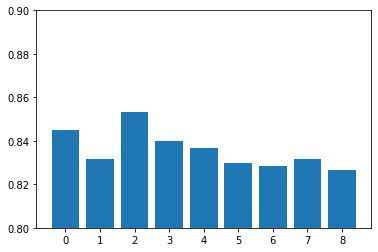

In [27]:
from fastFM import mcmc
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# feature list
candidate_colums = [
    ['applied', 'userID', 'jobID'],
    ['applied', 'userID', 'jobID', 'skill_check'],
    ['applied', 'userID', 'jobID', 'skill_check', 'word2vec_sim'],
    ['applied', 'userID', 'jobID', 'skill_check', 'cosine_sim'],
    ['applied', 'userID', 'jobID', 'cosine_sim'],
    ['applied', 'userID', 'jobID', 'word2vec_sim'],
    ['applied', 'userID', 'jobID', 'word2vec_sim', 'cosine_sim'],
    ['applied', 'userID', 'jobID', 'word2vec_sim', 'cosine_sim', 'companyID'],
    ['applied', 'userID', 'jobID', 'word2vec_sim', 'cosine_sim', 'companySize'],    
#     ['applied', 'userID', 'jobID', 'skill_check', 'companyID'],
#     ['applied', 'userID', 'jobID', 'skill_check', 'companySize']
]

# hyperparams
n_iter = 100
rank = 10
seed = 123
init_stdev = 0.1

acc_list = []

for i, col in enumerate(candidate_colums):
    filtered_data = train[col].dropna()
    
    v = DictVectorizer()
    
    # feature
    X_more_feature = v.fit_transform(
        list(filtered_data.drop(['applied'], axis=1).T.to_dict().values())
    )
    
    # label
    y_more_feature = np.array(filtered_data['applied'].tolist())
    
    # train test split
    X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(
        X_more_feature, y_more_feature, test_size=0.1, random_state=99
    )
    
    # train
    fm = mcmc.FMClassification(n_iter=n_iter, rank=rank, random_state=seed, init_stdev=init_stdev)
    y_pred = fm.fit_predict(X_mf_train, y_mf_train, X_mf_test)
    
    # acc
    acc = accuracy_score(y_mf_test, y_pred)
    print(i, 'acc:', acc, col)
    acc_list.append(acc)

from matplotlib import pyplot as plt

ind = np.arange(len(acc_list))
bar = plt.bar(ind, height=acc_list)
plt.xticks(ind, list(range(0, len(acc_list))))
plt.ylim((0.80, 0.90))

most_acc = np.array(acc_list).argsort()[::-1][0]
print('most_acc: ', most_acc)
candidate_colums[most_acc][1:]

# 모델

- neural net (mxnet)

In [28]:
import mxnet as mx
from sklearn.model_selection import train_test_split

# 훈련, 검증 세트 만들기
X_train, X_valid, y_train, y_valid = train_test_split(
    train[['userID_n', 'jobID_n', 'skill_check', 'word2vec_sim']], 
    train['applied'], 
    test_size=0.1, 
    random_state=99
)

# batch
n_train = len(train)
batch_size = 20

# train set
X_train = mx.io.NDArrayIter({
    'user': np.array(X_train['userID_n'].tolist()),
    'job': np.array(X_train['jobID_n'].tolist()),
    'sc': np.array(X_train['skill_check'].tolist()),
    'w2v': np.array(X_train['word2vec_sim'].tolist())
}, 
    label = np.array(y_train.tolist()), 
    batch_size = batch_size
)

X_eval = mx.io.NDArrayIter({
    'user': np.array(X_valid['userID_n'].tolist()), 
    'job': np.array(X_valid['userID_n'].tolist()),
    'sc': np.array(X_valid['skill_check'].tolist()),
    'w2v': np.array(X_valid['word2vec_sim'].tolist())
}, 
    label = np.array(y_valid.tolist()), 
    batch_size = batch_size
)

X_test = mx.io.NDArrayIter({
    'user': np.array(test['userID_n'].tolist()), 
    'job': np.array(test['userID_n'].tolist()),
    'sc': np.array(test['skill_check'].tolist()),
    'w2v': np.array(test['word2vec_sim'].tolist())
}, 
    label = np.zeros(len(test)), 
    batch_size = 1
)

In [30]:
user = mx.symbol.Variable('user')
user = mx.symbol.Embedding(data=user, input_dim=n_train, output_dim=50)

job = mx.symbol.Variable('job')
job = mx.symbol.Embedding(data=job, input_dim=n_train, output_dim=50)

sc = mx.symbol.Variable('sc')
sc = mx.symbol.Embedding(data=sc, input_dim=n_train, output_dim=10)

w2v = mx.symbol.Variable('w2v')
w2v = mx.symbol.Embedding(data=w2v, input_dim=n_train, output_dim=10)

y_true = mx.symbol.Variable('softmax_label')

nn = mx.symbol.concat(user, job, sc, w2v)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
relu = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=relu, num_hidden=256)
relu = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=relu, num_hidden=256)
relu = mx.symbol.Activation(data=nn, act_type='relu') 
nn = mx.symbol.FullyConnected(data=relu, num_hidden=64)
relu = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=relu, num_hidden=2)

mx.viz.plot_network(nn)

y_pred = mx.symbol.SoftmaxOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.cpu(), data_names=('user', 'job', 'sc', 'w2v'), symbol=y_pred)

model.fit(X_train, num_epoch=10, optimizer='adam', optimizer_params=(('learning_rate', 0.01),),
          eval_metric='acc', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 5931.30 samples/sec	accuracy=0.857769
INFO:root:Epoch[0] Train-accuracy=0.857037
INFO:root:Epoch[0] Time cost=0.924
INFO:root:Epoch[0] Validation-accuracy=0.856667
INFO:root:Epoch[1] Batch [0-250]	Speed: 5961.02 samples/sec	accuracy=0.858167
INFO:root:Epoch[1] Train-accuracy=0.857037
INFO:root:Epoch[1] Time cost=0.914
INFO:root:Epoch[1] Validation-accuracy=0.856667
INFO:root:Epoch[2] Batch [0-250]	Speed: 5127.36 samples/sec	accuracy=0.856773
INFO:root:Epoch[2] Train-accuracy=0.856111
INFO:root:Epoch[2] Time cost=1.058
INFO:root:Epoch[2] Validation-accuracy=0.856667
INFO:root:Epoch[3] Batch [0-250]	Speed: 4891.34 samples/sec	accuracy=0.856574
INFO:root:Epoch[3] Train-accuracy=0.855926
INFO:root:Epoch[3] Time cost=1.109
INFO:root:Epoch[3] Validation-accuracy=0.856667
INFO:root:Epoch[4] Batch [0-250]	Speed: 4416.44 samples/sec	accuracy=0.857769
INFO:root:Epoch[4] Train-accuracy=0.857037
INFO:root:Epoch[4] Time cost=1.226
INFO:root:Epoch[4] Validatio

In [31]:
# output

# softmax 결과가 0.5 보다 크거나 같으면 1
result = model.predict(X_test)[:,1].asnumpy()
result[result < 0.5] = 0
result[result >= 0.5] = 1

result_name = "./result/output_job_%s.csv" % str(int(datetime.datetime.now().timestamp()))
print(result_name)
result = pd.DataFrame(result.astype('int32'), columns=['applied'])
result.to_csv(result_name, index=False)

./result/output_job_1576418320.csv
